#  Partial report (improved): 
Given a city aerial image, let's try how to best extract which areas are mainly building areas. This notebook is attempt to experiment with methods and see what better fits the project's purpose.


In [243]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

In [244]:
# nomalize numpy ndarray to [0,2^8-1]
def normalize(matrix):
    max = np.amax(matrix)
    min = np.amin(matrix)
    matrix = (matrix - min) / (max - min)
    matrix *= ((2**8)-1)

    return matrix

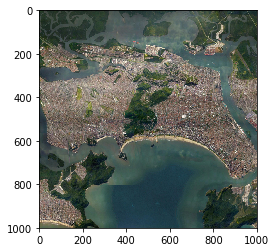

In [245]:
img = imageio.imread('PNGimages/santos.png')
plt.imshow(img)

Text(0.5,1,'Blue')

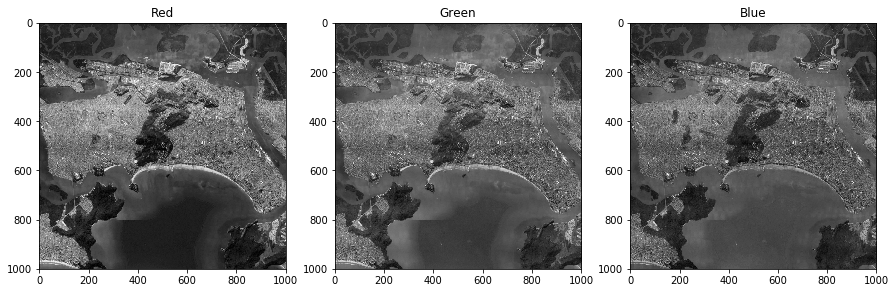

In [160]:
# showing each channel separately
r = img[:,:,0]
g = img[:,:,1]
b = img[:,:,2]
plt.figure(figsize=(15,10))
plt.subplot(131); plt.imshow(r, cmap="gray"); plt.title("Red")
plt.subplot(132); plt.imshow(g, cmap="gray"); plt.title("Green")
plt.subplot(133); plt.imshow(b, cmap="gray"); plt.title("Blue")

Apparently, city areas tend to be more reddish gray, at least for brazilian cities. Trying not to bump plain soil will maybe be difficult for the scope of the project, let me try at least to exclude vegetation and water areas,  

First, we use established vegetation indices to find how to better exclude it.

Text(0.5,1,'VVI')

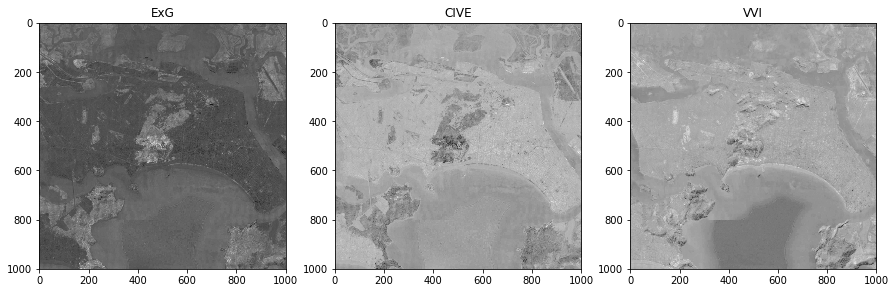

In [241]:
# try different indices to detect vegetation areas
r = r.astype(float)
g = g.astype(float)
b = b.astype(float)
R = r/abs(r+g+b+10)
G = g/abs(r+g+b+10)
B = b/abs(r+g+b+10)

ExG = 2*G - R - B
CIVE = 0.441*R - 0.811*G + 0.385*B + 18.787
RGBo = np.array([40,60,10])
VVI = (1 - abs(((R+10)-RGBo[0]) / ((R+10)+ RGBo[0]))) 
VVI *=  (1 - abs(((G+10)-RGBo[1]) / ((G+10)+ RGBo[1])))
VVI *=  (1 - abs(((B+10)-RGBo[2]) / ((B+10)+ RGBo[2])))

plt.figure(figsize=(15,10))
plt.subplot(131); plt.imshow(ExG, cmap="gray"); plt.title("ExG")
plt.subplot(132); plt.imshow(CIVE, cmap="gray"); plt.title("CIVE")
plt.subplot(133); plt.imshow(VVI, cmap="gray"); plt.title("VVI")

Appart from ExG (which needs some equalization), the results don't  seem too useful. Playing around with parameters won't kill anybody (afaik).

Text(0.5,1,'VVI')

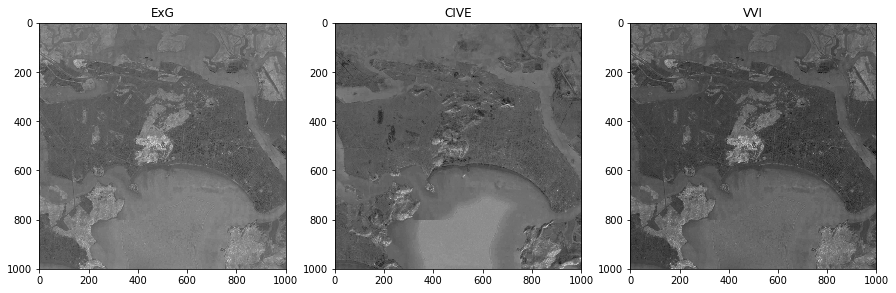

In [275]:
# adapt indices experimenting with parameters
ExG = 5*G - 3*R - 1*B
CIVE = - 0.441*R - 0.411*G + 0.385*B + 18.787
RGBo = np.array([1,120,10])
VVI = (1 - abs(((R+10)-RGBo[0]) / ((R+10)+ RGBo[0]))) 
VVI *=  (1 - abs(((G+10)-RGBo[1]) / ((G+10)+ RGBo[1])))
VVI *=  (1 - abs(((B+10)-RGBo[2]) / ((B+10)+ RGBo[2])))

plt.figure(figsize=(15,10))
plt.subplot(131); plt.imshow(ExG, cmap="gray"); plt.title("ExG")
plt.subplot(132); plt.imshow(CIVE, cmap="gray"); plt.title("CIVE")
plt.subplot(133); plt.imshow(VVI, cmap="gray"); plt.title("VVI")

It seems ExG(maybe in higher contrast) and VVI select vegetation well. Let's try to adapt them to select water bodies. 

Text(0.5,1,'VWI')

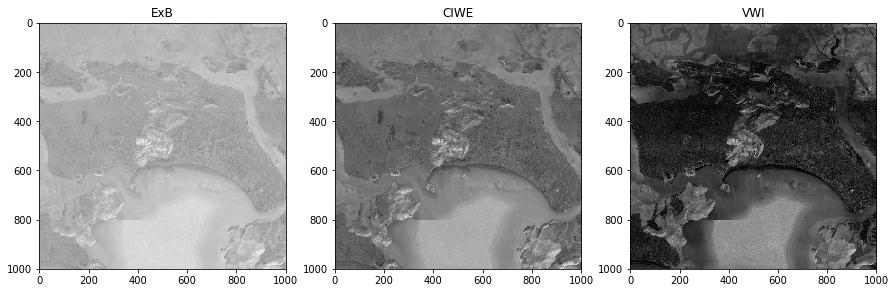

In [279]:
# adapt indices experimenting with parameters
ExB = -1.0*R +7.5*G +10*B 
CIWE = -0.741*R + 0.145*G + 0.985*B + 18.787
RGBo = np.array([10,60,100])
VVI = (1 - abs(((R+10)-RGBo[0]) / ((r+10)+ RGBo[0]))) 
VVI *=  (1 - abs(((G+10)-RGBo[1]) / ((g+10)+ RGBo[1])))
VVI *=  (1 - abs(((B+10)-RGBo[2]) / ((b+10)+ RGBo[2]))) 

plt.figure(figsize=(15,10))
plt.subplot(131); plt.imshow(ExB, cmap="gray"); plt.title("ExB")
plt.subplot(132); plt.imshow(CIWE, cmap="gray"); plt.title("CIWE")
plt.subplot(133); plt.imshow(VWI, cmap="gray"); plt.title("VWI")

CIWE seems to capture water better. It's still getting a lot of forest areas, but thats expected, since river and sea regions have strong green components, so vegetation is still caught by this improvised water indices.
Now we try to apply a red version of the filters, as to catch soil.

Text(0.5,1,'VSI')

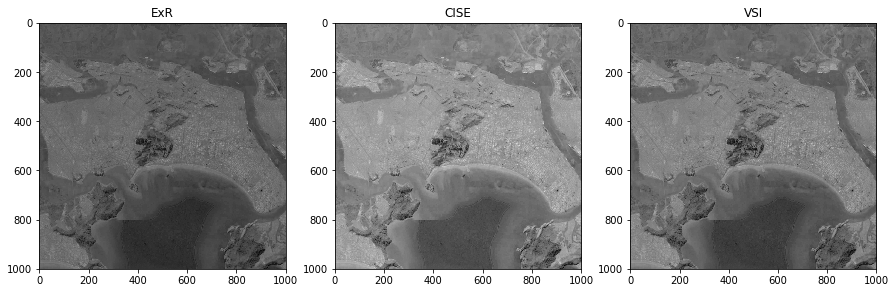

In [281]:
# adapt indices experimenting with parameters
ExR = 2.5*R - 5.0*B - 4.5*G
CISE = 0.575*R - 0.211*G - 0.385*B + 18.787
RGBo = np.array([100,5,5])
VSI = (1 - abs(((R+10)-RGBo[0]) / ((R+10)+ RGBo[0]))) 
VSI *=  (1 - abs(((G+10)-RGBo[1]) / ((G+10)+ RGBo[1])))
VSI *=  (1 - abs(((B+10)-RGBo[2]) / ((B+10)+ RGBo[2])))
plt.figure(figsize=(15,10))
plt.subplot(131); plt.imshow(ExR, cmap="gray"); plt.title("ExR")
plt.subplot(132); plt.imshow(CISE, cmap="gray"); plt.title("CISE")
plt.subplot(133); plt.imshow(VSI, cmap="gray"); plt.title("VSI")

This time the ExR and CISE seems more interesting. Lets prepare the indice images for getting the best combination to extract cities. We first need to select the best options. For this lets do some histogram equalization so we can better vizualize.

In [212]:
# function took from https://github.com/maponti/imageprocessing_course_icmc
def histogram(A, no_levels):
    # gets the size of the input matrix
    N, M = A.shape
    hist = np.zeros(no_levels).astype(int)
    for i in range(no_levels):
        
        pixels_value_i = np.where(A == i)
        hist[i] = pixels_value_i[0].shape[0]
            
    return(hist)

In [215]:
# function took from https://github.com/maponti/imageprocessing_course_icmc
def histogram_equalization(A, no_levels):
    hist = histogram(A,  no_levels)
    
    histC = np.zeros(no_levels).astype(int)

    histC[0] = hist[0] 
    for i in range(1,  no_levels):
        histC[i] = hist[i] + histC[i-1]

    hist_transform = np.zeros(no_levels).astype(np.uint8)
    N, M = A.shape
    A_eq = np.zeros([N,M]).astype(np.uint8)
    
    
    for r in range(no_levels):
        s = ((no_levels-1)/float(M*N))*histC[r]
        A_eq[ np.where(A == r) ] = s
    
    return A_eq

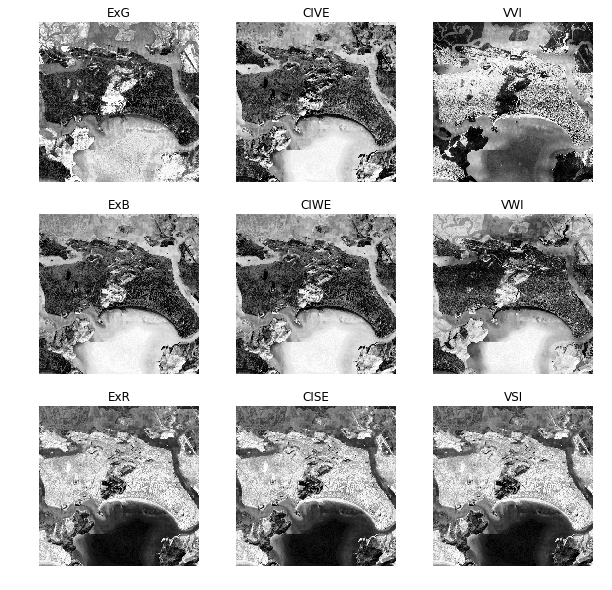

In [287]:
#normalizing
ExG = normalize(ExG).astype(np.uint8)
CIVE = normalize(CIVE).astype(np.uint8) 
VVI = normalize(VVI).astype(np.uint8)

ExB = normalize(ExB).astype(np.uint8)
CIWE = normalize(CIWE).astype(np.uint8) 
VWI = normalize(VWI).astype(np.uint8)

ExR = normalize(ExR).astype(np.uint8)
CISE = normalize(CISE).astype(np.uint8) 
VSI = normalize(VSI).astype(np.uint8)

#equalizing
hist_ExG = histogram_equalization(ExG, 256)
hist_CIVE = histogram_equalization(CIVE, 256) 
hist_VVI = histogram_equalization(VVI, 256)

hist_ExB = histogram_equalization(ExB, 256)
hist_CIWE = histogram_equalization(CIWE, 256) 
hist_VWI = histogram_equalization(VWI, 256)

hist_ExR = histogram_equalization(ExR, 256)
hist_CISE = histogram_equalization(CISE, 256) 
hist_VSI = histogram_equalization(VSI, 256)

#plotting
plt.figure(figsize=(10,10)) 
plt.subplot(331)
plt.imshow(hist_ExG, cmap="gray"); plt.title("ExG")
plt.axis('off')
plt.subplot(332)
plt.imshow(hist_CIVE, cmap="gray"); plt.title("CIVE")
plt.axis('off')
plt.subplot(333)
plt.imshow(hist_VVI, cmap="gray"); plt.title("VVI")
plt.axis('off')

plt.subplot(334)
plt.imshow(hist_ExB, cmap="gray"); plt.title("ExB")
plt.axis('off')
plt.subplot(335)
plt.imshow(hist_CIWE, cmap="gray"); plt.title("CIWE")
plt.axis('off')
plt.subplot(336)
plt.imshow(hist_VWI, cmap="gray"); plt.title("VWI")
plt.axis('off')

plt.subplot(337)
plt.imshow(hist_ExR, cmap="gray"); plt.title("ExR")
plt.axis('off')
plt.subplot(338)
plt.imshow(hist_CISE, cmap="gray"); plt.title("CISE")
plt.axis('off')
plt.subplot(339)
plt.imshow(hist_VSI, cmap="gray"); plt.title("VSI")
plt.axis('off')

plt.show()

Some interesting (and a weird) results. Using a combination of indices may render a better extraction. For subtraction, thresholding of unintended areas is a nice option.

For the removal of vegetation and water we select a combination of 
thresholded ExG and CIWE, as they seem good candidates. The threshold value is obtained from Otsu Thresholding.

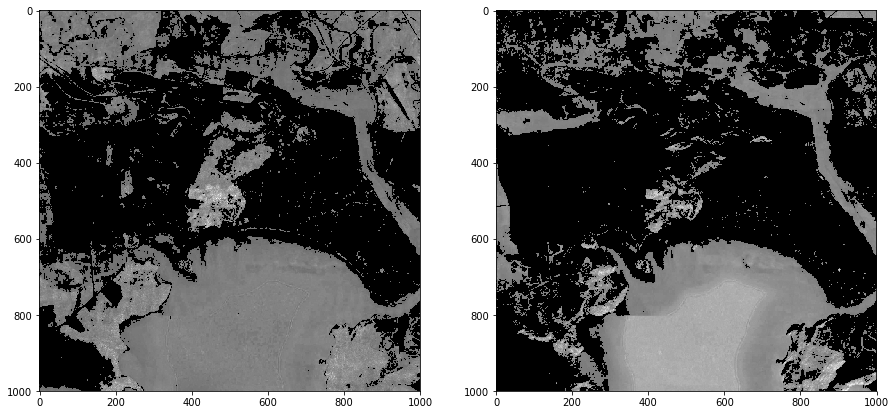

In [329]:
from skimage import filters
exg_thresh = filters.threshold_otsu(ExG)
ciwe_thresh = filters.threshold_otsu(CIWE)

tExG = np.where(ExG<exg_thresh, 0, ExG)
tCIWE = np.where(CIWE<ciwe_thresh, 0, CIWE)

plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(tExG, cmap='gray')

plt.subplot(122)
plt.imshow(tCIWE, cmap='gray')

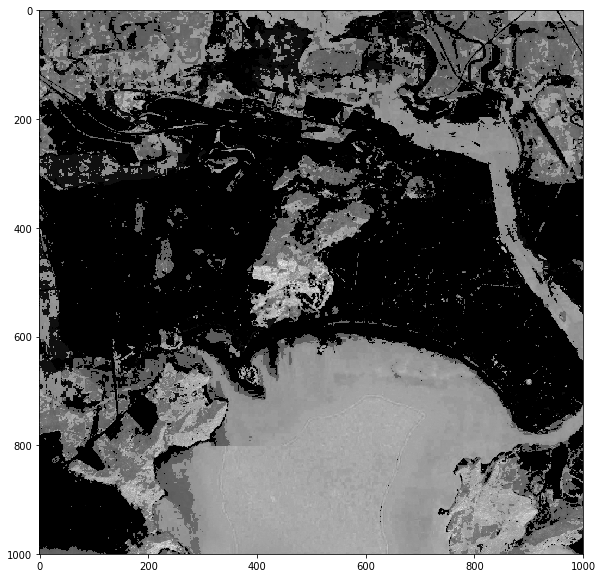

In [384]:
VW = 0.7*tExG + 0.3*tCIWE
VW = normalize(VW)
vw_thresh = filters.threshold_otsu(VW)

VW = np.where(VW<vw_thresh, VW*0.5, VW*1.5)
plt.figure(figsize=(15,10))
plt.imshow(VW,cmap='gray')

This result seems promissing: now maybe it il render a good combination with a enhanced soil image or maybe its invertion is enough. Any of the options are quite similar, so lets experiment.

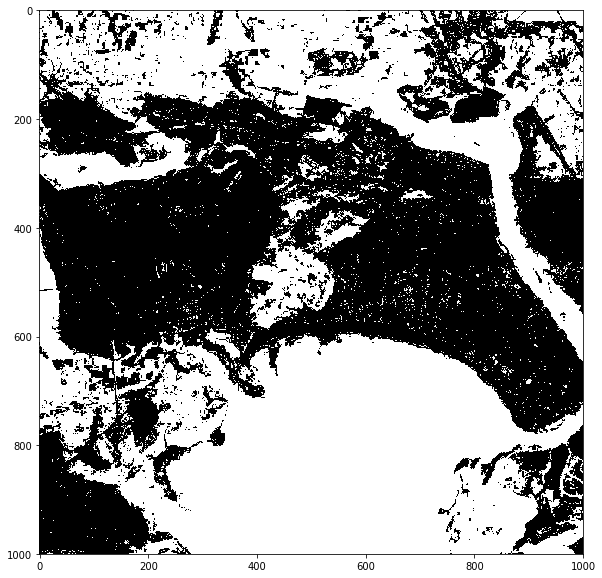

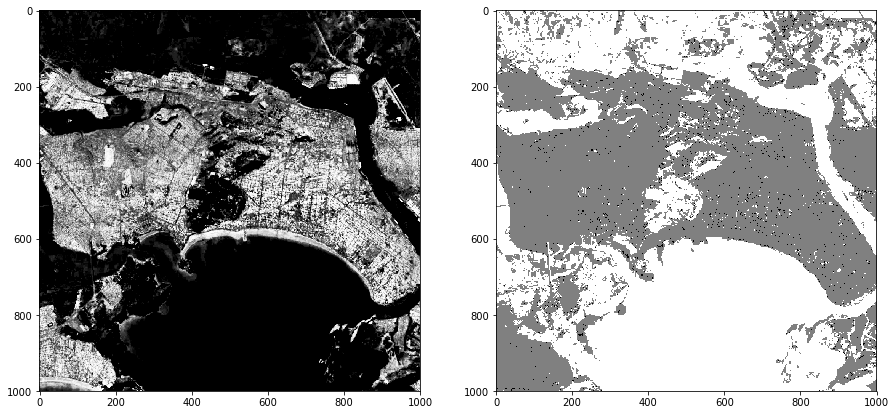

In [403]:
exr_t = np.mean(ExR)
tExR = np.where(ExR<exr_t, 0, ExR)
tExR = histogram_equalization(tExR,256)

tIVW = normalize(tIVW)
tIVW = 255.0 - tIVW
plt.figure(figsize=(15,10))
plt.imshow(tIVW,cmap='gray')
tIVW = histogram_equalization(tIVW,256)

plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(tExR, cmap='gray')
plt.subplot(122)
plt.imshow(tIVW, cmap='gray')